<a href="https://colab.research.google.com/github/shariqfarhan/Explore/blob/master/Assignment_5_Step_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Summary

This file is to implement the following Normalizations in a MNIST model. We want to determine how each normalization affects the model performance. 

Also, we try to understand where the model is failing. In order to do so, we need to see the examples where the model has incorrect predictions.

We do so for each of the normalization techniques.


1.   Network with Group Normalization
2.   Network with Layer Normalization
3.   Network with L1 Regularization + Batch Normalization


**Target**


1.   Define neural network in such a way that we can do any normalization in the same network
2.   Identify sample mis-classified images for each normalization technique


**Result**

*   We were able to successfully create a neural network with all 3 different types of Normalizations
*   We also implemented L1 Regularization for the model with Batch Normalization


**Analysis**

1.   For MNIST dataset, L1 + Batch Normalization & Group Normalization have a positive effect on model performance i.e. both of these improve model performance
1.   But Layer Normalization drastically reduces the model performance, such that the accuracy hovers < 10%
2.   As the number of epochs increase, Group Normalization (GN) performs better than L1 Regularization + Batch Normalization (BN). We see a clear superiority in test accuracy in GN especially after 10th epoch.
3.   Although the Test losses for GN aren't lower than L1 + BN, the test accuracy is higher 



## Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from typing import Union, List
import torch
from torch import nn, Size

In [ ]:
# We use this experimental data to identify the mean and std dev of the dataset

# simple transform
simple_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                      #  transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])
exp = datasets.MNIST('./data', train=True, download=True, transform=simple_transforms)
exp_data = exp.train_data
exp_data = exp.transform(exp_data.numpy())

print('[Train]')
print(' - Numpy Shape:', exp.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', exp.train_data.size())
print(' - min:', torch.min(exp_data))
print(' - max:', torch.max(exp_data))
print(' - mean:', torch.mean(exp_data))
print(' - std:', torch.std(exp_data))
print(' - var:', torch.var(exp_data))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


## Data Import & transformation

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmts
dataloader_args = dict(shuffle=True, batch_size=64, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


torch.Size([64, 1, 28, 28])
torch.Size([64])


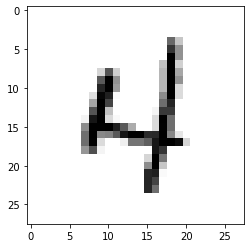

In [ ]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
# train_data = train.train_data
# train_data = train.transform(train_data.numpy())

# print('[Train]')
# print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
# print(' - Tensor Shape:', train.train_data.size())
# print(' - min:', torch.min(train_data))
# print(' - max:', torch.max(train_data))
# print(' - mean:', torch.mean(train_data))
# print(' - std:', torch.std(train_data))
# print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


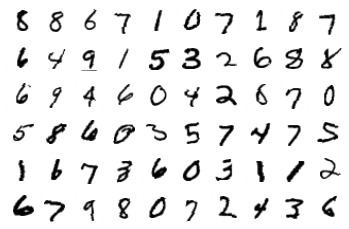

In [ ]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

## Model

Defining the model & Initialising it

In [4]:
# We change the way we define the neural network. Earlier we used to work one convolution layer at a time, now we'll add more operations on top of the convolution layer
# All of this will fall under 1 block.
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self, use_ln: bool = False, use_BN: bool = True, use_GN:bool = False):
        super(Net, self).__init__()
        self.use_ln = use_ln # Initializing the Layer Normalization variable - If set to True, Layer Normalization is True
        self.use_BN = use_BN # Initializing the Batch Normalization variable - If set to True, Batch Normalization is True
        self.use_GN = use_GN # Initializing the Group Normalization variable - If set to True, Group Normalization is True
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=4, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(4)  if self.use_BN else nn.Identity(),
            nn.ReLU(),
            nn.LayerNorm(26, elementwise_affine = False) if self.use_ln else nn.Identity(), # 26 is the Output from the 1st layer of Conv
            nn.GroupNorm(2, 4) if self.use_GN else nn.Identity() # We split 4 channels into 2 Groups
        ) # Input - 28 x 28 x 1 | Output - 26 x 26 x 4 | RF - 3 | Kernel - 3 x 3 x 1 x 4

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=4, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8)  if self.use_BN else nn.Identity(),
            nn.ReLU(),
            nn.LayerNorm(24, elementwise_affine = False) if self.use_ln else nn.Identity() , # 24 is the Output from the 2nd layer of Conv
            nn.GroupNorm(2, 8) if self.use_GN else nn.Identity() # We split 8 channels into 2 Groups
        ) # Input - 26 x 26 x 4 | Output - 24 x 24 x 8 | RF - 5 | Kernel - 3 x 3 x 4 x 8
        
        # TRANSITION BLOCK 1
        
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        # Input - 24 x 24 x 8 | Output - 12 x 12 x 8 | RF - 10 | Kernel - 2 x 2

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16)   if self.use_BN else nn.Identity(),
            nn.ReLU(),
            nn.LayerNorm(10, elementwise_affine = False) if self.use_ln else nn.Identity(), # 10 is the Output from the 1st layer of Conv
            nn.GroupNorm(2, 16) if self.use_GN else nn.Identity(), # We split 16 channels into 2 Groups
            nn.Dropout(dropout_value)
        ) # Input - 12 x 12 x 8 | Output - 10 x 10 x 16 | RF - 12 | Kernel - 3 x 3 x 8 x 16
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
            #nn.BatchNorm2d(16),
            #nn.ReLU(),
            #nn.Dropout(dropout_value)
          # If we increase the number of channels to 32, it increases the number of parameters by 4.6K, hence maintaining the channels at 16 
          # What is the benefit of having this block then? 
        ) # Input - 10 x 10 x 16 | Output - 10 x 10 x 16 | RF - 12 | Kernel - 3 x 3 x 16 x 16

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16)   if self.use_BN else nn.Identity(),
            nn.LayerNorm(8, elementwise_affine = False) if self.use_ln else nn.Identity(),
            nn.GroupNorm(2, 16) if self.use_GN else nn.Identity(), # We split 16 channels into 2 Groups
            nn.ReLU(),
            nn.Dropout(dropout_value)
          # If we increase the number of channels to 32, it increases the number of parameters by 4.6K, hence maintaining the channels at 16 
          # What is the benefit of having this block then? 
        ) # Input - 8 x 8 x 16 | Output - 8 x 8 x 16 | RF - 14 | Kernel - 3 x 3 x 16 x 16

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16)   if self.use_BN else nn.Identity(),
            nn.ReLU(),
            nn.LayerNorm(6, elementwise_affine = False) if self.use_ln else nn.Identity(),
            nn.GroupNorm(2, 16) if self.use_GN else nn.Identity() # We split 16 channels into 2 Groups
        ) # Input - 8 x 8 x 16 | Output - 6 x 6 x 16 | RF - 16 | Kernel - 3 x 3 x 16 x 16
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10)   if self.use_BN else nn.Identity(),
            nn.ReLU(),
            nn.LayerNorm(4, elementwise_affine = False) if self.use_ln else nn.Identity(),
            nn.GroupNorm(2, 10) if self.use_GN else nn.Identity() # We split 10 channels into 2 Groups
        ) # Input - 6 x 6 x 16 | Output - 4 x 4 x 10 | RF - 18 | Kernel - 3 x 3 x 16 x 10
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        ) # output_size = 1
        # ) # Input - 6 x 6 x 10 | Output - 1 x 1 x 10 | RF - 21 | Kernel - 6 x 6 x 10 x 10
        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) # ) # Input - 1 x 1 x 10 | Output - 1 x 1 x 10 | RF - 21 | Kernel - 1 x 1 x 10 x 10
        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.gap(x)
        x = self.convblock9(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

## Model Parameters

In [5]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 26, 26]              36
       BatchNorm2d-2            [-1, 4, 26, 26]               8
              ReLU-3            [-1, 4, 26, 26]               0
          Identity-4            [-1, 4, 26, 26]               0
          Identity-5            [-1, 4, 26, 26]               0
            Conv2d-6            [-1, 8, 24, 24]             288
       BatchNorm2d-7            [-1, 8, 24, 24]              16
              ReLU-8            [-1, 8, 24, 24]               0
          Identity-9            [-1, 8, 24, 24]               0
         Identity-10            [-1, 8, 24, 24]               0
           Conv2d-11           [-1, 16, 24, 24]             128
        MaxPool2d-12           [-1, 16, 12, 12]               0

## Training & Testing the Neural Network

Run the model and check 

In [6]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []
incorr_X = []
incorr_y = []
incorr_argmax = []


def train(model, device, train_loader, optimizer, epoch, l1_penalty = False, lambda_l1 = 0):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    if l1_penalty:
      l1 = 0
      for p in model.parameters():
        l1 = l1 + p.abs().sum()
      loss = loss + lambda_l1 * l1

    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            # The below code is added to identify misclassified images

            for idx, i in enumerate(output):
              if torch.argmax(i) == target[idx]:
                correct += 0 
                # To avoid double counting we don't add 1 here. If the above line of code ``` correct += pred.eq(target.view_as(pred)).sum().item() ```
                # wasn't there, we would add 1 here
              else:
                incorr_X.append(data)
                incorr_y.append(target)
                incorr_argmax.append(torch.argmax(i))

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

## Testing our model

In [7]:
from torch.optim.lr_scheduler import StepLR

train_losses = []
test_losses = []
train_acc = []
test_acc = []
incorrect_preds_x = []
incorrect_preds_y_true = []
incorrect_preds_y_pred = []

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch, lambda_l1 = 1e-5, l1_penalty = True)
    scheduler.step()
    test(model, device, test_loader)

l1_bn_train_losses = train_losses
l1_bn_test_losses = test_losses
l1_bn_train_acc = train_acc
l1_bn_test_acc = test_acc
l1_bn_preds_raw = incorr_X
l1_bn_preds_y_true = incorr_y
l1_bn_preds_y_pred = incorr_argmax

EPOCH: 0


Loss=0.09168388694524765 Batch_id=937 Accuracy=89.70: 100%|██████████| 938/938 [00:24<00:00, 37.89it/s]



Test set: Average loss: 0.0508, Accuracy: 9858/10000 (98.58%)

EPOCH: 1


Loss=0.0684998482465744 Batch_id=937 Accuracy=97.77: 100%|██████████| 938/938 [00:24<00:00, 38.91it/s]



Test set: Average loss: 0.0425, Accuracy: 9872/10000 (98.72%)

EPOCH: 2


Loss=0.024721546098589897 Batch_id=937 Accuracy=98.13: 100%|██████████| 938/938 [00:23<00:00, 39.44it/s]



Test set: Average loss: 0.0341, Accuracy: 9886/10000 (98.86%)

EPOCH: 3


Loss=0.021421102806925774 Batch_id=937 Accuracy=98.36: 100%|██████████| 938/938 [00:23<00:00, 39.48it/s]



Test set: Average loss: 0.0263, Accuracy: 9923/10000 (99.23%)

EPOCH: 4


Loss=0.023757360875606537 Batch_id=937 Accuracy=98.41: 100%|██████████| 938/938 [00:24<00:00, 38.86it/s]



Test set: Average loss: 0.0266, Accuracy: 9916/10000 (99.16%)

EPOCH: 5


Loss=0.023033779114484787 Batch_id=937 Accuracy=98.62: 100%|██████████| 938/938 [00:23<00:00, 39.24it/s]



Test set: Average loss: 0.0219, Accuracy: 9933/10000 (99.33%)

EPOCH: 6


Loss=0.037481293082237244 Batch_id=937 Accuracy=98.95: 100%|██████████| 938/938 [00:23<00:00, 39.70it/s]



Test set: Average loss: 0.0194, Accuracy: 9937/10000 (99.37%)

EPOCH: 7


Loss=0.010852206498384476 Batch_id=937 Accuracy=98.98: 100%|██████████| 938/938 [00:24<00:00, 39.03it/s]



Test set: Average loss: 0.0179, Accuracy: 9944/10000 (99.44%)

EPOCH: 8


Loss=0.12385158240795135 Batch_id=937 Accuracy=99.02: 100%|██████████| 938/938 [00:24<00:00, 38.79it/s]



Test set: Average loss: 0.0185, Accuracy: 9935/10000 (99.35%)

EPOCH: 9


Loss=0.018658462911844254 Batch_id=937 Accuracy=99.02: 100%|██████████| 938/938 [00:24<00:00, 38.27it/s]



Test set: Average loss: 0.0168, Accuracy: 9942/10000 (99.42%)

EPOCH: 10


Loss=0.034972384572029114 Batch_id=937 Accuracy=99.11: 100%|██████████| 938/938 [00:24<00:00, 38.17it/s]



Test set: Average loss: 0.0171, Accuracy: 9943/10000 (99.43%)

EPOCH: 11


Loss=0.05664286017417908 Batch_id=937 Accuracy=99.12: 100%|██████████| 938/938 [00:24<00:00, 38.34it/s]



Test set: Average loss: 0.0183, Accuracy: 9935/10000 (99.35%)

EPOCH: 12


Loss=0.012543046846985817 Batch_id=937 Accuracy=99.12: 100%|██████████| 938/938 [00:24<00:00, 38.75it/s]



Test set: Average loss: 0.0172, Accuracy: 9939/10000 (99.39%)

EPOCH: 13


Loss=0.012444483116269112 Batch_id=937 Accuracy=99.15: 100%|██████████| 938/938 [00:24<00:00, 38.29it/s]



Test set: Average loss: 0.0169, Accuracy: 9939/10000 (99.39%)

EPOCH: 14


Loss=0.08680955320596695 Batch_id=937 Accuracy=99.16: 100%|██████████| 938/938 [00:24<00:00, 39.05it/s]



Test set: Average loss: 0.0172, Accuracy: 9942/10000 (99.42%)

EPOCH: 15


Loss=0.04592803493142128 Batch_id=937 Accuracy=99.13: 100%|██████████| 938/938 [00:24<00:00, 38.86it/s]



Test set: Average loss: 0.0166, Accuracy: 9941/10000 (99.41%)

EPOCH: 16


Loss=0.04884573072195053 Batch_id=937 Accuracy=99.14: 100%|██████████| 938/938 [00:24<00:00, 39.07it/s]



Test set: Average loss: 0.0168, Accuracy: 9940/10000 (99.40%)

EPOCH: 17


Loss=0.015327336266636848 Batch_id=937 Accuracy=99.13: 100%|██████████| 938/938 [00:24<00:00, 38.91it/s]



Test set: Average loss: 0.0169, Accuracy: 9939/10000 (99.39%)

EPOCH: 18


Loss=0.0474785752594471 Batch_id=937 Accuracy=99.19: 100%|██████████| 938/938 [00:23<00:00, 39.10it/s]



Test set: Average loss: 0.0166, Accuracy: 9943/10000 (99.43%)

EPOCH: 19


Loss=0.024221356958150864 Batch_id=937 Accuracy=99.21: 100%|██████████| 938/938 [00:23<00:00, 39.31it/s]



Test set: Average loss: 0.0169, Accuracy: 9943/10000 (99.43%)



In [9]:
# l1_bn_test_losses = [t.cpu().item() for t in l1_bn_test_losses]
# l1_bn_test_acc = [t.cpu().item() for t in l1_bn_test_acc]
print(l1_bn_test_losses)
print(l1_bn_test_acc)

[0.050816266983747485, 0.04249048512428999, 0.03414390414878726, 0.026319664645940065, 0.02662842731177807, 0.021897499649599195, 0.0193857859140262, 0.01794480517376214, 0.01849581659901887, 0.016830034876521675, 0.017089069712907076, 0.018256955092493445, 0.01722764380592853, 0.016938238548114895, 0.01717870110180229, 0.01655710698105395, 0.016834878081735224, 0.016871643438190222, 0.016577229116298258, 0.016858592562680134]
[98.58, 98.72, 98.86, 99.23, 99.16, 99.33, 99.37, 99.44, 99.35, 99.42, 99.43, 99.35, 99.39, 99.39, 99.42, 99.41, 99.4, 99.39, 99.43, 99.43]


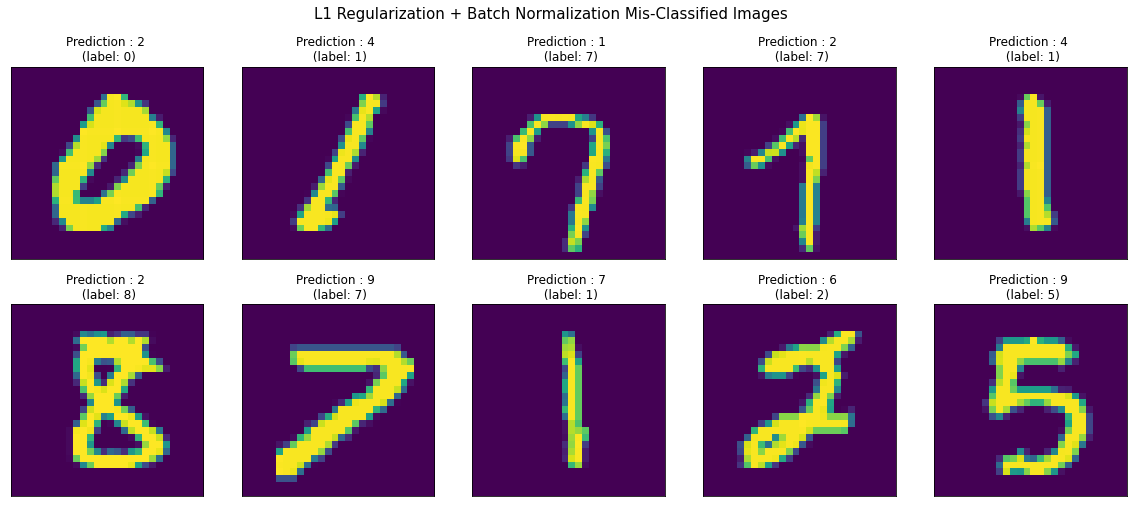

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
fig = plt.figure(figsize=(20, 8))
fig.suptitle("L1 Regularization + Batch Normalization Mis-Classified Images", fontsize=15)
for idx in range(10):
  ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
  img = np.squeeze(l1_bn_preds_raw[idx][idx])
  img_pred = l1_bn_preds_y_pred[idx].item()
  img_true = l1_bn_preds_y_true[idx][idx].item()
  plt.imshow(img.cpu().numpy())
  ax.set_title(f"Prediction : {img_pred} \n (label: {img_true})")



In [ ]:
import numpy as np
t = [t.cpu().item() for t in train_losses]

Text(0.5, 1.0, 'Test Accuracy')

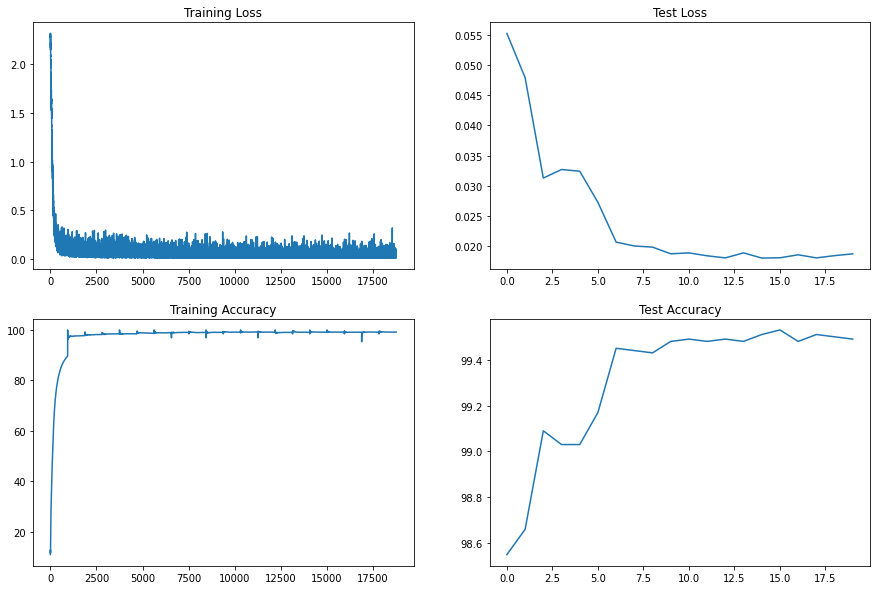

In [ ]:


fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

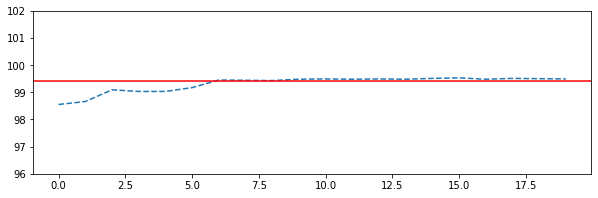

In [ ]:
ymin = 96
ymax = 102
plt.figure(figsize=(10, 3))
#plt.plot(train_acc, label = 'train_acc', linestyle = "--")
plt.plot(test_acc, label = 'test_acc', linestyle = "--")
plt.axhline(y=99.4, color='r', linestyle='-')
plt.ylim(ymin, ymax)
plt.show()

In [ ]:
print('Total Model Parameters : ', sum(p.numel() for p in model.parameters()))
print('Best Train Accuracy : ', max(train_acc))
print('Best Test Accuracy : ', max(test_acc))
x = [x for x in test_acc if x >= 99.4]
print('# of Epochs with test accuracy above 99.4% threshold:', len(x))

Total Model Parameters :  9300
Best Train Accuracy :  100.0
Best Test Accuracy :  99.53
# of Epochs with test accuracy above 99.4% threshold: 14


In [32]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net(use_ln = True, use_BN = False).to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 26, 26]              36
          Identity-2            [-1, 4, 26, 26]               0
              ReLU-3            [-1, 4, 26, 26]               0
         LayerNorm-4            [-1, 4, 26, 26]               0
          Identity-5            [-1, 4, 26, 26]               0
            Conv2d-6            [-1, 8, 24, 24]             288
          Identity-7            [-1, 8, 24, 24]               0
              ReLU-8            [-1, 8, 24, 24]               0
         LayerNorm-9            [-1, 8, 24, 24]               0
         Identity-10            [-1, 8, 24, 24]               0
           Conv2d-11           [-1, 16, 24, 24]             128
        MaxPool2d-12           [-1, 16, 12, 12]               0
           Conv2d-13           [-1, 16, 10, 10]           2,304
         Identity-14           [-1

In [14]:
from torch.optim.lr_scheduler import StepLR

train_losses = []
test_losses = []
train_acc = []
test_acc = []
incorrect_preds_x = []
incorrect_preds_y_true = []
incorrect_preds_y_pred = []


model =  Net(use_ln = True, use_BN = False).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)


ln_train_losses = train_losses
ln_test_losses = test_losses
ln_train_acc = train_acc
ln_test_acc = test_acc
ln_preds_raw = incorr_X
ln_preds_y_true = incorr_y
ln_preds_y_pred = incorr_argmax

EPOCH: 0


Loss=2.3025848865509033 Batch_id=937 Accuracy=9.87: 100%|██████████| 938/938 [00:21<00:00, 42.86it/s]



Test set: Average loss: 2.3026, Accuracy: 980/10000 (9.80%)

EPOCH: 1


Loss=2.3025848865509033 Batch_id=937 Accuracy=9.87: 100%|██████████| 938/938 [00:21<00:00, 42.98it/s]



Test set: Average loss: 2.3026, Accuracy: 981/10000 (9.81%)

EPOCH: 2


Loss=2.3025848865509033 Batch_id=937 Accuracy=9.87: 100%|██████████| 938/938 [00:21<00:00, 44.02it/s]



Test set: Average loss: 2.3026, Accuracy: 979/10000 (9.79%)

EPOCH: 3


Loss=2.3025848865509033 Batch_id=937 Accuracy=9.87: 100%|██████████| 938/938 [00:21<00:00, 43.45it/s]



Test set: Average loss: 2.3026, Accuracy: 979/10000 (9.79%)

EPOCH: 4


Loss=2.3025848865509033 Batch_id=937 Accuracy=9.87: 100%|██████████| 938/938 [00:21<00:00, 43.35it/s]



Test set: Average loss: 2.3026, Accuracy: 980/10000 (9.80%)

EPOCH: 5


Loss=2.3025848865509033 Batch_id=937 Accuracy=9.87: 100%|██████████| 938/938 [00:21<00:00, 43.57it/s]



Test set: Average loss: 2.3026, Accuracy: 980/10000 (9.80%)

EPOCH: 6


Loss=2.3025848865509033 Batch_id=937 Accuracy=9.87: 100%|██████████| 938/938 [00:22<00:00, 42.54it/s]



Test set: Average loss: 2.3026, Accuracy: 980/10000 (9.80%)

EPOCH: 7


Loss=2.3025848865509033 Batch_id=937 Accuracy=9.87: 100%|██████████| 938/938 [00:21<00:00, 43.03it/s]



Test set: Average loss: 2.3026, Accuracy: 981/10000 (9.81%)

EPOCH: 8


Loss=2.3025848865509033 Batch_id=937 Accuracy=9.87: 100%|██████████| 938/938 [00:21<00:00, 43.28it/s]



Test set: Average loss: 2.3026, Accuracy: 981/10000 (9.81%)

EPOCH: 9


Loss=2.3025848865509033 Batch_id=937 Accuracy=9.87: 100%|██████████| 938/938 [00:21<00:00, 43.69it/s]



Test set: Average loss: 2.3026, Accuracy: 981/10000 (9.81%)

EPOCH: 10


Loss=2.3025848865509033 Batch_id=937 Accuracy=9.87: 100%|██████████| 938/938 [00:21<00:00, 43.22it/s]



Test set: Average loss: 2.3026, Accuracy: 980/10000 (9.80%)

EPOCH: 11


Loss=2.3025848865509033 Batch_id=937 Accuracy=9.87: 100%|██████████| 938/938 [00:21<00:00, 43.57it/s]



Test set: Average loss: 2.3026, Accuracy: 980/10000 (9.80%)

EPOCH: 12


Loss=2.3025848865509033 Batch_id=937 Accuracy=9.87: 100%|██████████| 938/938 [00:21<00:00, 43.25it/s]



Test set: Average loss: 2.3026, Accuracy: 980/10000 (9.80%)

EPOCH: 13


Loss=2.3025848865509033 Batch_id=937 Accuracy=9.87: 100%|██████████| 938/938 [00:22<00:00, 42.23it/s]



Test set: Average loss: 2.3026, Accuracy: 980/10000 (9.80%)

EPOCH: 14


Loss=2.3025848865509033 Batch_id=937 Accuracy=9.87: 100%|██████████| 938/938 [00:21<00:00, 43.14it/s]



Test set: Average loss: 2.3026, Accuracy: 980/10000 (9.80%)

EPOCH: 15


Loss=2.3025848865509033 Batch_id=937 Accuracy=9.87: 100%|██████████| 938/938 [00:21<00:00, 43.71it/s]



Test set: Average loss: 2.3026, Accuracy: 979/10000 (9.79%)

EPOCH: 16


Loss=2.3025848865509033 Batch_id=937 Accuracy=9.87: 100%|██████████| 938/938 [00:21<00:00, 43.63it/s]



Test set: Average loss: 2.3026, Accuracy: 980/10000 (9.80%)

EPOCH: 17


Loss=2.3025848865509033 Batch_id=937 Accuracy=9.87: 100%|██████████| 938/938 [00:21<00:00, 42.79it/s]



Test set: Average loss: 2.3026, Accuracy: 980/10000 (9.80%)

EPOCH: 18


Loss=2.3025848865509033 Batch_id=937 Accuracy=9.87: 100%|██████████| 938/938 [00:21<00:00, 43.15it/s]



Test set: Average loss: 2.3026, Accuracy: 980/10000 (9.80%)

EPOCH: 19


Loss=2.3025848865509033 Batch_id=937 Accuracy=9.87: 100%|██████████| 938/938 [00:21<00:00, 43.43it/s]



Test set: Average loss: 2.3026, Accuracy: 980/10000 (9.80%)



In [15]:
print(ln_test_losses)
print(ln_test_acc)

[2.302584887313843, 2.302584887313843, 2.302584887313843, 2.302584887313843, 2.302584887313843, 2.302584887313843, 2.302584887313843, 2.302584887313843, 2.302584887313843, 2.302584887313843, 2.302584887313843, 2.302584887313843, 2.302584887313843, 2.302584887313843, 2.302584887313843, 2.302584887313843, 2.302584887313843, 2.302584887313843, 2.302584887313843, 2.302584887313843]
[9.8, 9.81, 9.79, 9.79, 9.8, 9.8, 9.8, 9.81, 9.81, 9.81, 9.8, 9.8, 9.8, 9.8, 9.8, 9.79, 9.8, 9.8, 9.8, 9.8]


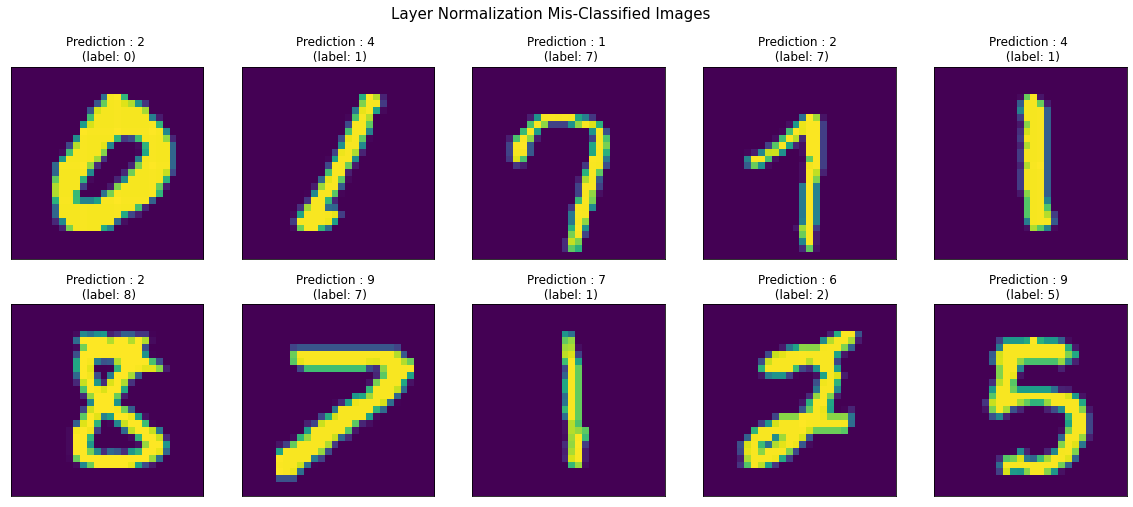

In [16]:
import numpy as np
fig = plt.figure(figsize=(20, 8))
fig.suptitle("Layer Normalization Mis-Classified Images", fontsize=15)
for idx in range(10):
  ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
  img = np.squeeze(ln_preds_raw[idx][idx])
  img_pred = ln_preds_y_pred[idx].item()
  img_true = ln_preds_y_true[idx][idx].item()
  plt.imshow(img.cpu().numpy())
  ax.set_title(f"Prediction : {img_pred} \n (label: {img_true})")



In [33]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net(use_GN = True, use_BN = False).to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 26, 26]              36
          Identity-2            [-1, 4, 26, 26]               0
              ReLU-3            [-1, 4, 26, 26]               0
          Identity-4            [-1, 4, 26, 26]               0
         GroupNorm-5            [-1, 4, 26, 26]               8
            Conv2d-6            [-1, 8, 24, 24]             288
          Identity-7            [-1, 8, 24, 24]               0
              ReLU-8            [-1, 8, 24, 24]               0
          Identity-9            [-1, 8, 24, 24]               0
        GroupNorm-10            [-1, 8, 24, 24]              16
           Conv2d-11           [-1, 16, 24, 24]             128
        MaxPool2d-12           [-1, 16, 12, 12]               0
           Conv2d-13           [-1, 16, 10, 10]           2,304
         Identity-14           [-1

In [12]:
from torch.optim.lr_scheduler import StepLR

train_losses = []
test_losses = []
train_acc = []
test_acc = []
incorrect_preds_x = []
incorrect_preds_y_true = []
incorrect_preds_y_pred = []

model =  Net(use_GN = True, use_BN = False).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

GN_train_losses = train_losses
GN_test_losses = test_losses
GN_train_acc = train_acc
GN_test_acc = test_acc
GN_incorrect_preds_raw = incorr_X
GN_incorrect_preds_y_true = incorr_y
GN_incorrect_preds_y_pred = incorr_argmax

EPOCH: 0


Loss=0.020811444148421288 Batch_id=937 Accuracy=92.28: 100%|██████████| 938/938 [00:22<00:00, 42.19it/s]



Test set: Average loss: 0.0597, Accuracy: 9832/10000 (98.32%)

EPOCH: 1


Loss=0.15874741971492767 Batch_id=937 Accuracy=97.95: 100%|██████████| 938/938 [00:22<00:00, 42.06it/s]



Test set: Average loss: 0.0410, Accuracy: 9867/10000 (98.67%)

EPOCH: 2


Loss=0.006416083313524723 Batch_id=937 Accuracy=98.28: 100%|██████████| 938/938 [00:22<00:00, 42.32it/s]



Test set: Average loss: 0.0459, Accuracy: 9853/10000 (98.53%)

EPOCH: 3


Loss=0.031679049134254456 Batch_id=937 Accuracy=98.48: 100%|██████████| 938/938 [00:22<00:00, 41.16it/s]



Test set: Average loss: 0.0344, Accuracy: 9900/10000 (99.00%)

EPOCH: 4


Loss=0.00821490865200758 Batch_id=937 Accuracy=98.64: 100%|██████████| 938/938 [00:22<00:00, 42.05it/s]



Test set: Average loss: 0.0245, Accuracy: 9924/10000 (99.24%)

EPOCH: 5


Loss=0.008285008370876312 Batch_id=937 Accuracy=98.73: 100%|██████████| 938/938 [00:22<00:00, 41.91it/s]



Test set: Average loss: 0.0311, Accuracy: 9895/10000 (98.95%)

EPOCH: 6


Loss=0.010259345173835754 Batch_id=937 Accuracy=99.11: 100%|██████████| 938/938 [00:22<00:00, 42.22it/s]



Test set: Average loss: 0.0208, Accuracy: 9938/10000 (99.38%)

EPOCH: 7


Loss=0.002199079841375351 Batch_id=937 Accuracy=99.14: 100%|██████████| 938/938 [00:22<00:00, 41.67it/s]



Test set: Average loss: 0.0195, Accuracy: 9943/10000 (99.43%)

EPOCH: 8


Loss=0.03773936256766319 Batch_id=937 Accuracy=99.19: 100%|██████████| 938/938 [00:22<00:00, 41.40it/s]



Test set: Average loss: 0.0205, Accuracy: 9946/10000 (99.46%)

EPOCH: 9


Loss=0.012617959640920162 Batch_id=937 Accuracy=99.22: 100%|██████████| 938/938 [00:22<00:00, 42.23it/s]



Test set: Average loss: 0.0197, Accuracy: 9943/10000 (99.43%)

EPOCH: 10


Loss=0.00478389672935009 Batch_id=937 Accuracy=99.28: 100%|██████████| 938/938 [00:21<00:00, 42.66it/s]



Test set: Average loss: 0.0193, Accuracy: 9946/10000 (99.46%)

EPOCH: 11


Loss=0.03451894596219063 Batch_id=937 Accuracy=99.27: 100%|██████████| 938/938 [00:22<00:00, 41.75it/s]



Test set: Average loss: 0.0187, Accuracy: 9947/10000 (99.47%)

EPOCH: 12


Loss=0.001488662208430469 Batch_id=937 Accuracy=99.27: 100%|██████████| 938/938 [00:22<00:00, 41.90it/s]



Test set: Average loss: 0.0183, Accuracy: 9947/10000 (99.47%)

EPOCH: 13


Loss=0.05064229294657707 Batch_id=937 Accuracy=99.23: 100%|██████████| 938/938 [00:22<00:00, 41.67it/s]



Test set: Average loss: 0.0183, Accuracy: 9948/10000 (99.48%)

EPOCH: 14


Loss=0.0020981822162866592 Batch_id=937 Accuracy=99.28: 100%|██████████| 938/938 [00:22<00:00, 42.24it/s]



Test set: Average loss: 0.0183, Accuracy: 9949/10000 (99.49%)

EPOCH: 15


Loss=0.08937390148639679 Batch_id=937 Accuracy=99.27: 100%|██████████| 938/938 [00:22<00:00, 41.27it/s]



Test set: Average loss: 0.0184, Accuracy: 9948/10000 (99.48%)

EPOCH: 16


Loss=0.006046064663678408 Batch_id=937 Accuracy=99.33: 100%|██████████| 938/938 [00:23<00:00, 40.72it/s]



Test set: Average loss: 0.0184, Accuracy: 9948/10000 (99.48%)

EPOCH: 17


Loss=0.003527289954945445 Batch_id=937 Accuracy=99.25: 100%|██████████| 938/938 [00:22<00:00, 41.60it/s]



Test set: Average loss: 0.0183, Accuracy: 9948/10000 (99.48%)

EPOCH: 18


Loss=0.0021348504815250635 Batch_id=937 Accuracy=99.29: 100%|██████████| 938/938 [00:22<00:00, 41.64it/s]



Test set: Average loss: 0.0183, Accuracy: 9948/10000 (99.48%)

EPOCH: 19


Loss=0.0034499417524784803 Batch_id=937 Accuracy=99.30: 100%|██████████| 938/938 [00:22<00:00, 41.78it/s]



Test set: Average loss: 0.0183, Accuracy: 9948/10000 (99.48%)



In [13]:
print(GN_test_losses)
print(GN_test_acc)

[0.05968920709490776, 0.040997982002794746, 0.04587591888159513, 0.034422834575921296, 0.02446658178642392, 0.031140319967269896, 0.02077053785007447, 0.019462448521051556, 0.020525795961916445, 0.019676527062058448, 0.019315960242506116, 0.018726512882858516, 0.018342090644687413, 0.01831400238722563, 0.018314311401546, 0.018371036456152796, 0.018379286567494272, 0.018325759846530856, 0.0183339512553066, 0.018322013177629562]
[98.32, 98.67, 98.53, 99.0, 99.24, 98.95, 99.38, 99.43, 99.46, 99.43, 99.46, 99.47, 99.47, 99.48, 99.49, 99.48, 99.48, 99.48, 99.48, 99.48]


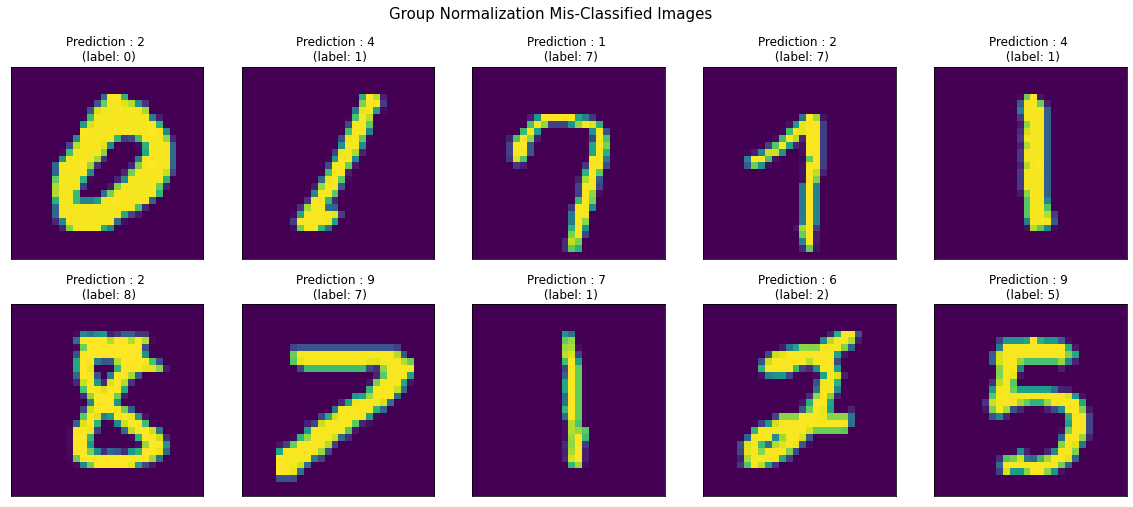

In [17]:
import numpy as np
fig = plt.figure(figsize=(20, 8))
fig.suptitle("Group Normalization Mis-Classified Images", fontsize=15)
for idx in range(10):
  ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
  img = np.squeeze(GN_incorrect_preds_raw[idx][idx])
  img_pred = GN_incorrect_preds_y_pred[idx].item()
  img_true = GN_incorrect_preds_y_true[idx][idx].item()
  plt.imshow(img.cpu().numpy())
  ax.set_title(f"Prediction : {img_pred} \n (label: {img_true})")



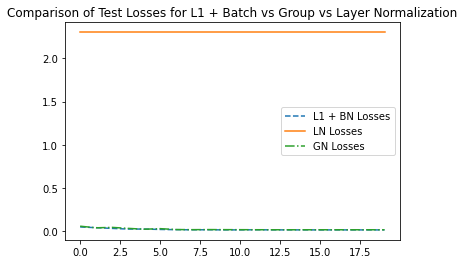

In [29]:
import matplotlib.pyplot as plt
x = list(range(20))
plt.plot(x, l1_bn_test_losses, label = "L1 + BN Losses", linestyle="--")
plt.plot(x, ln_test_losses, label = "LN Losses", linestyle="-")
plt.plot(x, GN_test_losses, label = "GN Losses", linestyle="-.")
plt.title('Comparison of Test Losses for L1 + Batch vs Group vs Layer Normalization')
plt.legend()
plt.show()

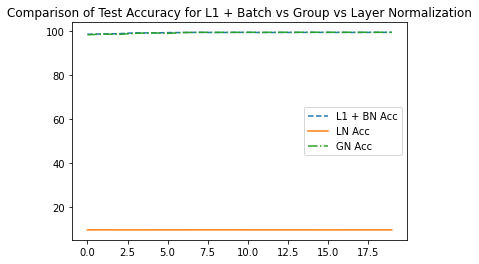

In [30]:
plt.plot(x, l1_bn_test_acc, label = "L1 + BN Acc", linestyle="--")
plt.plot(x, ln_test_acc, label = "LN Acc", linestyle="-")
plt.plot(x, GN_test_acc, label = "GN Acc", linestyle="-.")
plt.title('Comparison of Test Accuracy for L1 + Batch vs Group vs Layer Normalization')
plt.legend()
plt.show()

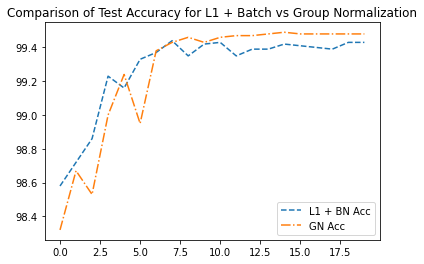

In [34]:
plt.plot(x, l1_bn_test_acc, label = "L1 + BN Acc", linestyle="--")
# plt.plot(x, ln_test_acc, label = "LN Losses", linestyle="-")
plt.plot(x, GN_test_acc, label = "GN Acc", linestyle="-.")
plt.title('Comparison of Test Accuracy for L1 + Batch vs Group Normalization')
plt.legend()
plt.show()

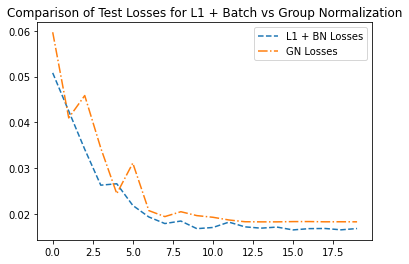

In [31]:
import matplotlib.pyplot as plt
x = list(range(20))
plt.plot(x, l1_bn_test_losses, label = "L1 + BN Losses", linestyle="--")
#plt.plot(x, ln_test_losses, label = "LN Losses", linestyle="-")
plt.plot(x, GN_test_losses, label = "GN Losses", linestyle="-.")
plt.title('Comparison of Test Losses for L1 + Batch vs Group Normalization')
plt.legend()
plt.show()

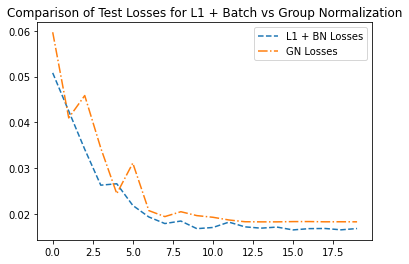

In [35]:
import matplotlib.pyplot as plt
x = list(range(20))
plt.plot(x, l1_bn_test_losses, label = "L1 + BN Losses", linestyle="--")
#plt.plot(x, ln_test_losses, label = "LN Losses", linestyle="-")
plt.plot(x, GN_test_losses, label = "GN Losses", linestyle="-.")
plt.title('Comparison of Test Losses for L1 + Batch vs Group Normalization')
plt.legend()
plt.show()